## ~Wrapping up CNN

In [0]:
from nb_fastai_9 import *

In [0]:
% reload_ext autoreload
% autoreload 2
% matplotlib inline

In [0]:
import ipywidgets as widgets

In [0]:
def f(o) :
    print("hi")

In [0]:
w = widgets.Button(description="Click me")

In [0]:
w

Button(description='Click me', style=ButtonStyle())

In [0]:
w.on_click(f)

In [0]:
from time import sleep

In [0]:
def show_calculation(cb=None):
    res = 0
    for i in range(5):
        res += i*i
        sleep(i)
        if cb:
            cb(i)
    return res

In [0]:
show_calculation(lambda x: print(f"Awesome! we've finished epoch {x}"))

Awesome! we've finished epoch 0
Awesome! we've finished epoch 1
Awesome! we've finished epoch 2
Awesome! we've finished epoch 3
Awesome! we've finished epoch 4


30

In [0]:
def show_progress(exc, epoch):
    print(f"{exc} We've cfinished epoch {epoch}")

In [0]:
from functools import partial

In [0]:
show_calculation(partial(show_progress, "Ok iguess"))

Ok iguess We've cfinished epoch 0
Ok iguess We've cfinished epoch 1
Ok iguess We've cfinished epoch 2
Ok iguess We've cfinished epoch 3
Ok iguess We've cfinished epoch 4


30

In [0]:
f2 = partial(show_progress, "Ok I guess")

In [0]:
f2

functools.partial(<function show_progress at 0x7f96bda5b510>, 'Ok I guess')

### Callbacks as callable classes

In [0]:
class ProgressShowingCallback():
    def __init__(self, exc="Awesome"):
        self.exc = exc
    def __call__(self, epoch):
        print(f"{self.exc} we have finidhed epoch {epoch}!")

In [0]:
cb = ProgressShowingCallback("Just super!")

In [0]:
show_calculation(cb)

Just super! we have finidhed epoch 0!
Just super! we have finidhed epoch 1!
Just super! we have finidhed epoch 2!
Just super! we have finidhed epoch 3!
Just super! we have finidhed epoch 4!


30

In [0]:
def slow_calculation(cb=None):
    res = 0
    for i in range(5):
        if cb:   cb.before_cal(i)
        res += i*i
        sleep(1)
        if cb:  cb.after_calc(i, val=res)
    return res

In [0]:
class PrintStepCallback():
    def __init__(self):
        pass
    def before_cal(self, epoch):
        print(f"About to start")
    def after_calc(self, *args, **kwargs):
        print(f"Done step")

In [0]:
slow_calculation(PrintStepCallback())

About to start
Done step
About to start
Done step
About to start
Done step
About to start
Done step
About to start
Done step


30

## Modify behavior

In [0]:
def slow_calculation(cb=None):
    res = 0
    for i in range(5):
        if cb and hasattr(cb, 'before_calc'):
            cb.before_calc(i)
        res += i*i
        sleep(1)
        if cb and hasattr(cb, 'after_calc'):
            if cb.after_calc(i, res):
                print("stopping early")
                break
    return res

In [0]:
class PrintAfterCallback():
    def after_calc(self, epoch, val):
        print(f"After {epoch}: {val}")
        if val > 10: 
            return True

In [0]:
slow_calculation(PrintAfterCallback())

After 0: 0
After 1: 1
After 2: 5
After 3: 14
stopping early


14

In [0]:
class SlowCalculator():
    def __init__(self, cb=None):
        self.cb, self.res = cb, 0.
        
    def __call__(self, cb_name, *args):
        if not self.cb:
            return
        cb = getattr(self.cb, cb_name, None)
        if cb: return cb(self, *args)
        
    def calc(self):
        for i in range(5):
            self("Before_calc", i)
            self.res += i*i
            sleep(1)
            if self("after_calc", i):
                print("stopping early")
                break

In [0]:
class ModifyingCallback():
    def after_calc(self, calc, epoch):
        print(f"After {epoch}: {calc.res}")
        if calc.res > 10: 
            return True
        if calc.res < 3:
            calc.res = calc.res * 2

In [0]:
calculator = SlowCalculator(ModifyingCallback())

In [0]:
calculator.calc()

After 0: 0.0
After 1: 1.0
After 2: 6.0
After 3: 15.0
stopping early


In [0]:
calculator.res

15.0



### Varience

Variance is the average of how far away each data point is from the mean

In [0]:
t = torch.tensor([1., 2., 4., 18])

In [0]:
m = t.mean()
m

tensor(6.2500)

In [0]:
(t-m).mean()

tensor(0.)

In [0]:
(t-m).abs().mean()

tensor(5.8750)

In [0]:
(t-m).pow(2).mean()

tensor(47.1875)



But the first of these is now a totally different scale, since we squared. So let's undo that at the end.


In [0]:
(t-m).pow(2).mean().sqrt()

tensor(6.8693)



They're still different. Why?

Note that we have one outlier (18). In the version where we square everything, it makes that much bigger than everything else.

(t-m).pow(2).mean() is refered to as variance. It's a measure of how spread out the data is, and is particularly sensitive to outliers.

When we take the sqrt of the variance, we get the standard deviation. Since it's on the same kind of scale as the original data, it's generally more interpretable. However, since sqrt(1)==1, it doesn't much matter which we use when talking about unit variance for initializing neural nets.

(t-m).abs().mean() is referred to as the mean absolute deviation. It isn't used nearly as much as it deserves to be, because mathematicians don't like how awkward it is to work with. But that shouldn't stop us, because we have computers and stuff.

Here's a useful thing to note about variance:


In [0]:
(t-m).pow(2).mean(), (t*t).mean() - (m*m)

(tensor(47.1875), tensor(47.1875))

### Covarience

Here's how Wikipedia defines covariance:

$$\operatorname{cov}(X,Y) = \operatorname{E}{\big[(X - \operatorname{E}[X])(Y - \operatorname{E}[Y])\big]}$$

In [0]:
u = t*2

In [0]:
u *= torch.randn_like(t)/10+0.95

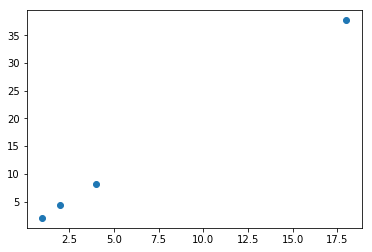

In [0]:
plt.scatter(t, u)

In [0]:
prod = (t-t.mean())*(u-u.mean())
prod

tensor([ 57.8970,  36.9114,  11.0352, 289.2564])

It's generally more conveniently defined like so:

$$\operatorname{E}\left[X Y\right] - \operatorname{E}\left[X\right] \operatorname{E}\left[Y\right]$$

In [0]:
prod.mean()

tensor(98.7750)

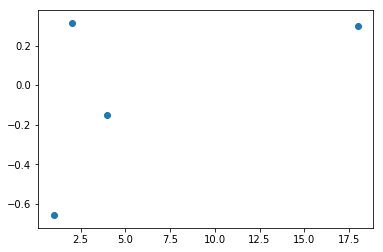

In [0]:
v = torch.randn_like(t)
plt.scatter(t, v)

In [0]:
cov = (t*v).mean() - t.mean()*v.mean()
cov

tensor(1.4983)

From now on, you're not allowed to look at an equation (or especially type it in LaTeX) without also typing it in Python and actually calculating some values. Ideally, you should also plot some values.

Finally, here is the Pearson correlation coefficient:

$$\rho_{X,Y}= \frac{\operatorname{cov}(X,Y)}{\sigma_X \sigma_Y}$$

In [0]:
cov / (t.std() * v.std())

tensor(0.4106)

### Softmax

which is:

$$\hbox{logsoftmax(x)}_{i} = x_{i} - \log \sum_{j} e^{x_{j}}$$ 

And our cross entropy loss is:
$$-\log(p_{i})$$

In [0]:
def log_softmax(x):
    return x - x.exp().sum(-1, keepdims=True).log()

In [0]:
log_softmax(cov)

tensor(0.)

# Early Stoping

## Better callback cancellation¶


In [0]:
x_train, y_train, x_valid, y_valid = get_data()

In [0]:
#export
class Dataset():
    def __init__(self, x, y):
        self.x, self.y = x, y
       
    def __len__(self):
        return len(self.x)
   
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [0]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [0]:
nh, bs = 50, 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy

In [0]:
nh, bs, c

(50, 512, 10)

In [0]:
def get_dls(train_dl, valid_dl, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
                DataLoader(valid_ds, batch_size=bs*2, shuffle=False, **kwargs))

In [0]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [0]:
#export
class Callback():
    _order = 0
    def set_runner(self, run):
        self.run = run
    
    def __getattr__(self, k):
        return getattr(self.run, k)
    
    @property
    def name(self):
        name = re.sub(r"Callback$", "", self.__class__.__name__)
        return camel2snake(name or 'callback')
    
    def __call__(self, cb_name):
        f = getattr(self, cb_name, None)
        if f and f():
            return True
        return False

class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs = 0
        self.run.n_iter = 0
        
    def after_batch(self):
        if not self.in_train:  return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter   += 1
        
    def begin_epoch(self):
        self.run.n_epochs = self.epoch
        self.model.train()
        self.run.in_train = True
        
    def begin_validate(self):
        self.model.eval()
        self.run.in_train = False
        
        
class CancelTrainException(Exception):  pass
class CancelEpochException(Exception):  pass
class CancelBatchException(Exception):  pass

In [0]:
#export
class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop,self.cbs = False,[TrainEvalCallback()]+cbs

    @property
    def opt(self):       return self.learn.opt
    @property
    def model(self):     return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self):      return self.learn.data

    def one_batch(self, xb, yb):
        self.xb,self.yb = xb,yb
        if self('begin_batch'): return
        self.pred = self.model(self.xb)
        if self('after_pred'): return
        self.loss = self.loss_func(self.pred, self.yb)
        if self('after_loss') or not self.in_train: return
        self.loss.backward()
        if self('after_backward'): return
        self.opt.step()
        if self('after_step'): return
        self.opt.zero_grad()

    def all_batches(self, dl):
        self.iters = len(dl)
        for xb,yb in dl:
            if self.stop: break
            self.one_batch(xb, yb)
            self('after_batch')
        self.stop=False

    def fit(self, epochs, learn):
        self.epochs,self.learn = epochs,learn

        try:
            for cb in self.cbs: cb.set_runner(self)
            if self('begin_fit'): return
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)

                with torch.no_grad(): 
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                if self('after_epoch'): break
            
        finally:
            self('after_fit')
            self.learn = None

    def __call__(self, cb_name):
        for cb in sorted(self.cbs, key=lambda x: x._order):
            f = getattr(cb, cb_name, None)
            if f and f(): return True
        return False

In [0]:
class Learner():
    def __init__(self, model, opt, loss_func, data):
        self.model, self.opt, self.loss_func, self.data = model, opt, loss_func, data

In [0]:
def get_model(data, lr=0.5, nh=50):
    m = data.train_ds.x.shape[1]
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c))
    return model, optim.SGD(model.parameters(), lr=lr)

In [0]:
learn = Learner(*get_model(data), loss_func, data)

In [0]:
class TestCallback(Callback):
    _order = 1
    def after_step(self):
        print(self.n_iter)
        if self.n_iter >= 10:
            raise CancelTrainException()

In [0]:
run = Runner(cb_funcs=TestCallback)

In [0]:
run.fit(3, learn)

In [0]:
#export
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats, self.valid_stats = AvgStats(metrics, True), AvgStats(metrics, False)
    
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad():
            stats.accumulate(self.run)
            
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)
        

In [0]:
class Recorder(Callback):
    def begin_fit(self):
        self.lrs = [[] for _ in self.opt.param_groups]
        self.losses = []

    def after_batch(self):
        if not self.in_train: return
        for pg,lr in zip(self.opt.param_groups,self.lrs): lr.append(pg['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self, pgid=-1): plt.plot(self.lrs[pgid])
    def plot_loss(self, skip_last=0): plt.plot(self.losses[:len(self.losses)-skip_last])
        
    def plot(self, skip_last=0, pgid=-1):
        losses = [o.item() for o in self.losses]
        lrs    = self.lrs[pgid]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(lrs[:n], losses[:n])

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs): self.pname,self.sched_funcs = pname,sched_funcs
        
    def begin_fit(self):
        if not isinstance(self.sched_funcs, (list,tuple)):
            self.sched_funcs = [self.sched_funcs] * len(self.opt.param_groups)

    def set_param(self):
        assert len(self.opt.param_groups)==len(self.sched_funcs)
        for pg,f in zip(self.opt.param_groups,self.sched_funcs):
            pg[self.pname] = f(self.n_epochs/self.epochs)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()

## LR Finder


NB: You may want to also add something that saves the model before running this, and loads it back after running - otherwise you'll lose your weights!

In [0]:
class LR_Find(Callback):
    _order = 1
    def __init__(self, max_iter = 100, min_lr=1e-6, max_lr=10):
        self.max_iter, self.min_lr, self.max_lr = max_iter, min_lr, max_lr
        self.best_loss = 1e9
        
    def begin_batch(self):
        if not self.in_train:   return
        pos = self.n_iter / self.max_iter
        lr = self.min_lr * (self.max_lr / self.min_lr)** pos
        for pg in self.opt.param_groups:
            pg['lr'] = lr
        
    def after_step(self):
        if self.n_iter >= self.max_iter or self.loss > self.best_loss * 10:
            raise CancelTrainException()
        if self.loss < self.best_loss:
            self.best_loss = self.loss

In [0]:
learn = Learner(*get_model(data), loss_func, data)

In [0]:
run = Runner(cb_funcs=[LR_Find, Recorder])

In [0]:
run.fit(3, learn)

In [0]:
run.recorder.plot(skip_last=5)

In [0]:
run.recorder.plot_lr()

### Create CuDa CNN

In [0]:
x_train, y_train, x_valid, y_valid = get_data()

In [0]:
#export
def normalize_to(train, valid):
    m, s = train.mean(), train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [0]:
x_train, x_valid = normalize_to(x_train, x_valid)

In [0]:
x_train.mean(), x_train.std()

(tensor(0.0001), tensor(1.))

In [0]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [0]:
nh, bs = 50, 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy

In [0]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [0]:
#export
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
        
    def forward(self, x):
        return self.func(x)
    
def flatten(x):
    return x.view(x.shape[0], -1)

In [0]:
def mnist_resize(x):
    return x.view(-1, 1, 28, 28)

In [0]:
def get_cnn_model(data):
    return nn.Sequential(
                Lambda(mnist_resize),
                nn.Conv2d(1, 8, 5, padding=2, stride=2),  nn.ReLU(),
                nn.Conv2d(8, 16, 3, padding=1, stride=2), nn.ReLU(),
                nn.Conv2d(16, 32, 3, padding=1, stride=2),nn.ReLU(),
                nn.Conv2d(32, 32, 3, padding=1, stride=2),nn.ReLU(),
                nn.AdaptiveAvgPool2d(1),
                Lambda(flatten),
                nn.Linear(32, c)
    )


In [0]:
model = get_cnn_model(data)

In [0]:
cbfs = [Recorder, partial(AvgStatsCallback, accuracy)]

In [0]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [0]:
% time run.fit(1, learn)

train: [1.8632353125, tensor(0.3620)]
valid: [1.1200458984375, tensor(0.6261)]
CPU times: user 4.34 s, sys: 115 ms, total: 4.45 s
Wall time: 4.52 s


## CUDA

This took a long time to run, so it's time to use a GPU. A simple Callback can make sure the model, inputs and targets are all on the same device.

In [0]:
device = torch.device("cuda", 0)

In [0]:
class CudaCallback(Callback):
    def __init__(self, device):
        self.device = device
        
    def begin_fit(self):
        self.model.to(deive)
        
    def begin_batch(self):
        self.run.xb, self.run.yb = self.xb.to(device), self.yb.to(device)

In [0]:
torch.cuda.set_device(device)

In [0]:
device

device(type='cuda', index=0)

In [0]:


#export
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.cuda(),self.yb.cuda()



In [0]:
cbfs.append(CudaCallback)

In [0]:
model = get_cnn_model(data)

In [0]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [0]:
#cbfs = [Recorder, partial(AvgStatsCallback, accuracy), CudaCallback]

In [0]:
% time run.fit(6, learn)

train: [1.934489375, tensor(0.3364, device='cuda:0')]
valid: [0.618364892578125, tensor(0.8098, device='cuda:0')]
train: [0.4131113671875, tensor(0.8741, device='cuda:0')]
valid: [0.1882626220703125, tensor(0.9458, device='cuda:0')]
train: [0.1830213671875, tensor(0.9444, device='cuda:0')]
valid: [0.1655798583984375, tensor(0.9527, device='cuda:0')]
train: [0.212151328125, tensor(0.9377, device='cuda:0')]
valid: [0.1265386962890625, tensor(0.9610, device='cuda:0')]
train: [0.11058892578125, tensor(0.9659, device='cuda:0')]
valid: [0.09357246704101563, tensor(0.9724, device='cuda:0')]
train: [0.0896465625, tensor(0.9726, device='cuda:0')]
valid: [0.1163880126953125, tensor(0.9640, device='cuda:0')]
CPU times: user 7.89 s, sys: 1.99 s, total: 9.88 s
Wall time: 13.1 s


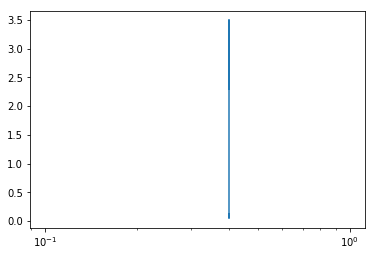

In [0]:
run.recorder.plot()

### Refactor model

In [0]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
                nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride),
                nn.ReLU()
        )



Another thing is that we can do the mnist resize in a batch transform, that we can do with a Callback.


In [0]:
#export
class BatchTransformXCallback(Callback):
    _order = 2
    def __init__(self, tfms):
        self.tfms = tfms
    
    def begin_batch(self):
        self.run.xb = self.tfms(self.xb)
        
        
def view_tfms(*size):
    def _inner(x):
        return x.view(*((-1,)+size))
    return _inner

In [0]:
mnist_view = view_tfms(1, 28, 28)
cbfs.append(partial(BatchTransformXCallback, mnist_view))

With the AdaptiveAvgPool, this model can now work on any size input:

In [0]:
nfs = [8, 16, 32, 32]

In [0]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))


And this helper function will quickly give us everything needed to run the training.

In [0]:
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func=F.cross_entropy):
    if opt_func is None:
        opt_func = optim.SGD
        opt = opt_func(model.parameters(), lr=lr)
        learn = Learner(model, opt, loss_func, data)
        return learn, Runner(cb_funcs=listify(cbs))

In [0]:
model = get_cnn_model(data, nfs)

In [0]:
learn, run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [0]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [0]:
run.fit(3, learn)

train: [1.58211140625, tensor(0.4733, device='cuda:0')]
valid: [0.41556904296875, tensor(0.8707, device='cuda:0')]
train: [0.3369216796875, tensor(0.8975, device='cuda:0')]
valid: [0.173126708984375, tensor(0.9499, device='cuda:0')]
train: [0.16831658203125, tensor(0.9488, device='cuda:0')]
valid: [0.15754361572265624, tensor(0.9543, device='cuda:0')]


# Hooks

## Manual insertion

Let's say we want to do some telemetry, and want the mean and standard deviation of each activations in the model. First we can do it manually like this:

In [0]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]
        
    def __call__(self, x):
        for i, l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.data.mean())
            self.act_stds [i].append(x.data.std())
        return x
    
    def __iter__(self):
        return iter(self.layers)

In [0]:
model = SequentialModel(*get_cnn_layers(data, nfs))
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [0]:
run.fit(5, learn)

train: [2.37478890625, tensor(0.1321, device='cuda:0')]
valid: [2.15559921875, tensor(0.3106, device='cuda:0')]
train: [1.078242421875, tensor(0.6362, device='cuda:0')]
valid: [0.29555478515625, tensor(0.9094, device='cuda:0')]
train: [0.8963659375, tensor(0.7172, device='cuda:0')]
valid: [1.635710546875, tensor(0.4978, device='cuda:0')]
train: [1.70223921875, tensor(0.4390, device='cuda:0')]
valid: [0.5659845703125, tensor(0.8248, device='cuda:0')]
train: [0.655670546875, tensor(0.7944, device='cuda:0')]
valid: [0.525035986328125, tensor(0.8313, device='cuda:0')]


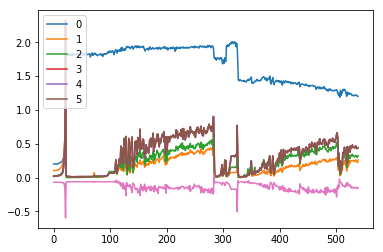

In [0]:
for l in model.act_means:
    plt.plot(l)
plt.legend(range(6))

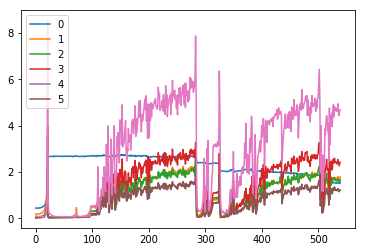

In [0]:
for l in model.act_stds:
    plt.plot(l)
plt.legend(range(6))

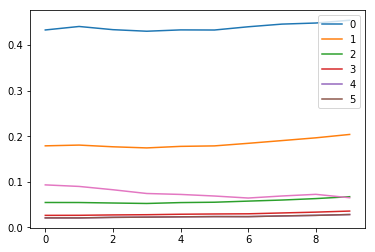

In [0]:
for l in model.act_stds:
    plt.plot(l[:10])
plt.legend(range(6))

## Pytorch hooks



Hooks are PyTorch object you can add to any nn.Module. A hook will be called when a layer, it is registered to, is executed during the forward pass (forward hook) or the backward pass (backward hook).

Hooks don't require us to rewrite the model.


In [0]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [0]:
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

In [0]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.data.mean())
    act_stds[i].append(outp.data.std())

## Hook class
We can refactor this in a Hook class. It's very important to remove the hooks when they are deleted, otherwise there will be references kept and the memory won't be properly released when your model is deleted.

Let's design our own class that can contain a list of objects. It will behave a bit like a numpy array in the sense that we can index into it via:
- a single index
- a slice (like 1:5)
- a list of indices
- a mask of indices (`[True,False,False,True,...]`)

The `__iter__` method is there to be able to do things like `for x in ...`.

#### torch.nn init

In [0]:
#export
def children(m):
    return list(m.children())


class Hook():
    def __init__(self, m, f):
        self.hook = m.register_forward_hook(partial(f, self))
        
    def remove(self):
        self.hook.remove()
        
    def __del__(self):
        self.remove()
        
        
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'):
        hook.stats = ([], [])
        means, stds = hook.stats
        means.append(outp.data.mean())
        stds.append(outp.data.std())



NB: In fastai we use a bool param to choose whether to make it a forward or backward hook. In the above version we're only supporting forward hooks.


In [0]:
#export
class ListContainer():
    def __init__(self, items):
        self.items = listify(items)
    
    def __getitem__(self, idx):
        if isinstance(idx, (int, slice)):
            return self.items[idx]
        if isinstance(idx[0], bool):
            assert len(idx) == len(self)
            return [o for m, o in zip(idx, self.items) if m]
        return [self.items[i] for i in idx]
    
    def __len__(self):
        return len(self.items)
    
    def __iter__(self):
        return iter(self.items)
    
    def __setitem__(self, i, o):
        self.items[i] = o
        
    def __delitem__(self, i):
        del(self.items[i])
        
    def __repr__(self):
        res = f"{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}"
        if len(self) > 10:
            res = res[:-1] + '...]'
        return res

In [0]:
ListContainer(range(10))

ListContainer (10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [0]:
ListContainer(range(100))

ListContainer (100 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]

We can use it to write a `Hooks` class that contains several hooks. We will also use it in the next notebook as a container for our objects in the data block API.

In [0]:
#export
from torch.nn import init

class Hooks(ListContainer):
    def __init__(self, ms, f):
        super().__init__([Hook(m, f) for m in ms])
    
    def __enter__(self, *args):
        return self
    
    def __exit__(self, *args):
        self.remove()
        
    def __del__(self):
        self.remove()
        
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self):
        for h in self:
            h.remove()

In [0]:
model = get_cnn_model(data, nfs).cuda()
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [0]:
hooks = Hooks(model, append_stats)
hooks

Hooks (7 items)
[<__main__.Hook object at 0x7f96b8f08a58>, <__main__.Hook object at 0x7f96b8f08860>, <__main__.Hook object at 0x7f96b8f08a20>, <__main__.Hook object at 0x7f96b8fdfac8>, <__main__.Hook object at 0x7f96b90847f0>, <__main__.Hook object at 0x7f96bd5710f0>, <__main__.Hook object at 0x7f96b8ff20f0>]

In [0]:
x, y = next(iter(data.train_dl))
x = mnist_resize(x).cuda()

In [0]:
x.mean(), x.std()

(tensor(0.0060, device='cuda:0'), tensor(1.0069, device='cuda:0'))

In [0]:
p = model[0](x)
p.mean(), p.std()

(tensor(0.1909, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.4047, device='cuda:0', grad_fn=<StdBackward0>))

Having given an `__enter__` and `__exit__` method to our `Hooks` class, we can use it as a context manager. This makes sure that onces we are out of the `with` block, all the hooks have been removed and aren't there to pollute our memory.

In [0]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [0]:
p = model[0](x)
p.mean(), p.std()

(tensor(0.4176, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.7733, device='cuda:0', grad_fn=<StdBackward0>))

train: [1.50207359375, tensor(0.4934, device='cuda:0')]
valid: [0.3546611083984375, tensor(0.8896, device='cuda:0')]
train: [0.28593595703125, tensor(0.9138, device='cuda:0')]
valid: [0.55216455078125, tensor(0.8660, device='cuda:0')]


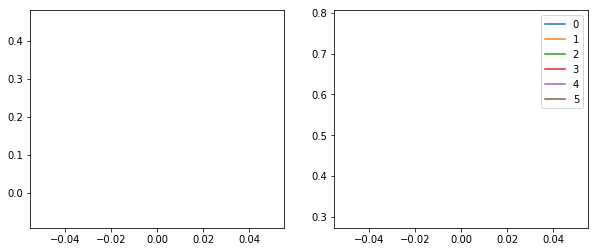

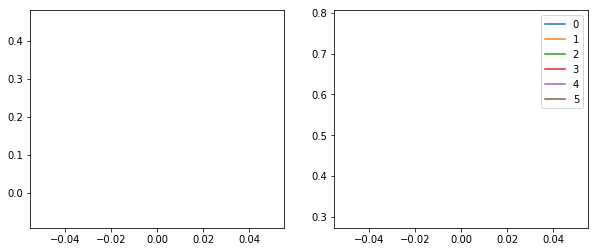

In [0]:
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6));

In [0]:
h.stats

([tensor(-0.0663, device='cuda:0')], [tensor(0.2969, device='cuda:0')])

## Generalized ReLU

In [0]:
#export
def get_cnn_layers(data, nfs, layers, **kwargs):
    nfs = [1] + nfs
    return [layers(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs)
                for i in range(len(nfs)-1)] + [nn.AdaptiveAvgPool2d(1),
                                              Lambda(flatten), nn.Linear(nfs[-1],c)]

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride),
                            GeneralRelu(**kwargs))

class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak, self.sub, self.maxv = leak, sub, maxv
        
    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None:
            x.sub_(self.sub)
        if self.maxv is not None:
            x.clamp_max_(self.maxv)
        return x
    
def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a=0.1)
            l[0].bias.data.zero_()
            
def get_cnn_model(data, nfs, layers, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layers, **kwargs))

## Other Statistics

Let's store more than the means and stds and plot histograms of our activations now.

In [0]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, "stats"):
        hook.stats = ([], [], [])
    means, stds, hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds.append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40, -7, 7))
        

In [0]:
model = get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model)
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

train: [0.5131118359375, tensor(0.8374, device='cuda:0')]
valid: [0.189028564453125, tensor(0.9407, device='cuda:0')]


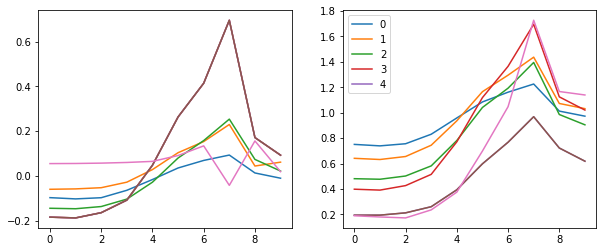

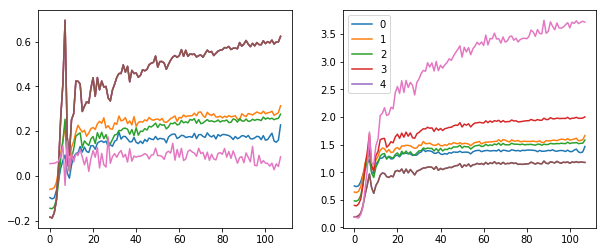

In [0]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    for h in hooks:
        ms, ss, hi = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(5))
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    for h in hooks:
        ms, ss, hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5));

In [0]:
def get_hist(h):
    return torch.stack(h.stats[2]).t().float().log1p()

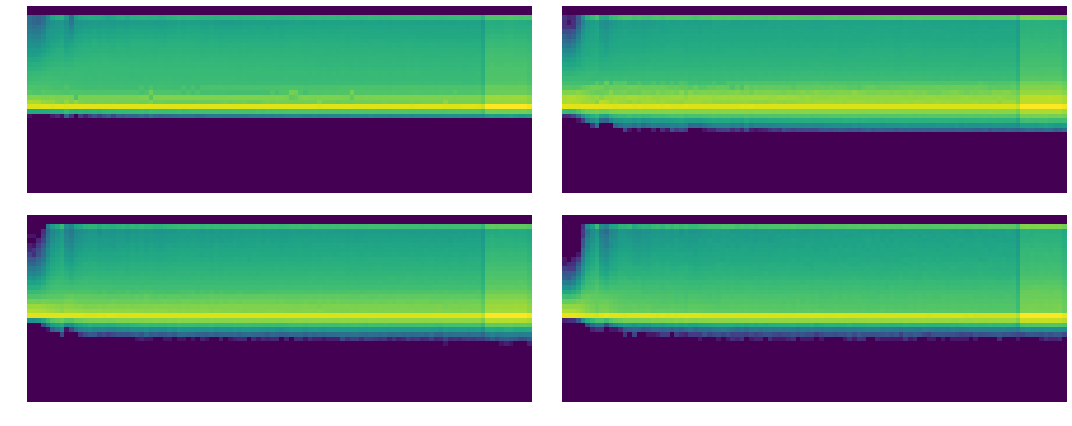

In [0]:
fig, axes = plt.subplots(2, 2, figsize=(15, 6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin="lower")
    ax.axis("off")
plt.tight_layout()

In [0]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[19: 22].sum(0) / h1.sum(0)

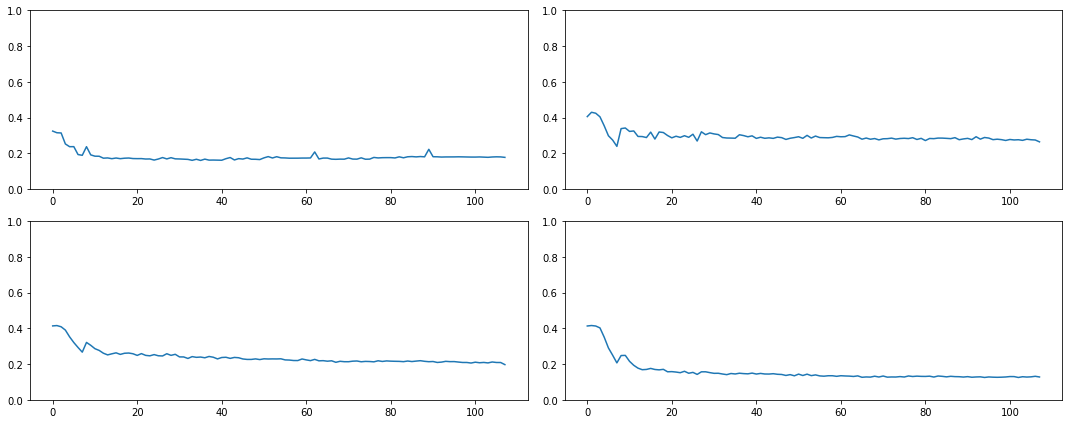

In [0]:
fig, axes = plt.subplots(2, 2, figsize=(15, 6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

In [0]:
#export
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [0]:
#export
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))



In [0]:
#export
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

In [0]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)])

In [0]:
learn, run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [0]:
run.fit(8, learn)

train: [1.1854578125, tensor(0.6262, device='cuda:0')]
valid: [0.6953166015625, tensor(0.8121, device='cuda:0')]
train: [0.32450935546875, tensor(0.9043, device='cuda:0')]
valid: [0.15230081787109376, tensor(0.9584, device='cuda:0')]
train: [0.18471498046875, tensor(0.9451, device='cuda:0')]
valid: [0.14281829833984375, tensor(0.9596, device='cuda:0')]
train: [0.23230984375, tensor(0.9327, device='cuda:0')]
valid: [0.11119857177734375, tensor(0.9660, device='cuda:0')]
train: [0.092397998046875, tensor(0.9720, device='cuda:0')]
valid: [0.0762672119140625, tensor(0.9783, device='cuda:0')]
train: [0.061268095703125, tensor(0.9807, device='cuda:0')]
valid: [0.0637205322265625, tensor(0.9835, device='cuda:0')]
train: [0.0447447900390625, tensor(0.9861, device='cuda:0')]
valid: [0.05927169799804687, tensor(0.9836, device='cuda:0')]
train: [0.03561955322265625, tensor(0.9896, device='cuda:0')]
valid: [0.059768505859375, tensor(0.9842, device='cuda:0')]


In [0]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, uniform=True,
                          cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [0]:
run.fit(8, learn)

train: [1.137040859375, tensor(0.6442, device='cuda:0')]
valid: [0.69640751953125, tensor(0.7737, device='cuda:0')]
train: [0.32491828125, tensor(0.9015, device='cuda:0')]
valid: [0.58625732421875, tensor(0.8187, device='cuda:0')]
train: [0.20849119140625, tensor(0.9362, device='cuda:0')]
valid: [0.11888934326171875, tensor(0.9649, device='cuda:0')]
train: [0.1296187890625, tensor(0.9611, device='cuda:0')]
valid: [0.0972892822265625, tensor(0.9717, device='cuda:0')]
train: [0.0851016796875, tensor(0.9739, device='cuda:0')]
valid: [0.07938566284179688, tensor(0.9763, device='cuda:0')]
train: [0.0605759912109375, tensor(0.9818, device='cuda:0')]
valid: [0.06885165405273437, tensor(0.9791, device='cuda:0')]
train: [0.044391884765625, tensor(0.9869, device='cuda:0')]
valid: [0.05994818115234375, tensor(0.9823, device='cuda:0')]
train: [0.036248076171875, tensor(0.9893, device='cuda:0')]
valid: [0.0582130615234375, tensor(0.9832, device='cuda:0')]


In [0]:


#export
from IPython.display import display, Javascript
def nb_auto_export():
    display(Javascript("""{
const ip = IPython.notebook
if (ip) {
    ip.save_notebook()
    console.log('a')
    const s = `!python notebook2script.py ${ip.notebook_name}`
    if (ip.kernel) { ip.kernel.execute(s) }
}
}"""))



In [0]:
nb_auto_export()

<IPython.core.display.Javascript object>

In [0]:
#  ! python notebook2script.py Untitled.ipynb

## BatchNorm

In [0]:
x_train, y_train, x_valid, y_valid = get_data()

In [0]:
x_train, x_valid = normalize_to(x_train, x_valid)
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [0]:
nh, bs = 50, 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [0]:
mnist_view = view_tfms(1, 28, 28)
cbfs = [Recorder, partial(AvgStatsCallback, accuracy), CudaCallback,
                   partial(BatchTransformXCallback, mnist_view)]

In [0]:
nfs = [8, 16, 32, 64, 64]

In [0]:
learn, run = get_learn_run(nfs, data, 0.6, conv_layer, cbs=cbfs)

In [0]:
% time run.fit(8, learn)

train: [0.13872298828125, tensor(0.9575, device='cuda:0')]
valid: [0.10789742431640625, tensor(0.9678, device='cuda:0')]
train: [0.10170916015625, tensor(0.9685, device='cuda:0')]
valid: [0.08718119506835938, tensor(0.9732, device='cuda:0')]
train: [0.2553732421875, tensor(0.9322, device='cuda:0')]
valid: [2.144715234375, tensor(0.2028, device='cuda:0')]
train: [0.828883515625, tensor(0.7265, device='cuda:0')]
valid: [0.15881876220703126, tensor(0.9515, device='cuda:0')]
train: [0.169352890625, tensor(0.9484, device='cuda:0')]
valid: [0.12899005126953125, tensor(0.9602, device='cuda:0')]
train: [0.12738240234375, tensor(0.9606, device='cuda:0')]
valid: [0.105679443359375, tensor(0.9672, device='cuda:0')]
train: [0.0892873046875, tensor(0.9725, device='cuda:0')]
valid: [0.15718321533203125, tensor(0.9539, device='cuda:0')]
train: [0.074925859375, tensor(0.9772, device='cuda:0')]
valid: [0.10417825927734375, tensor(0.9682, device='cuda:0')]
CPU times: user 11 s, sys: 3.86 s, total: 14.8 

# Batchnorm

## Custom BatchNorm

Let's start by building our own `BatchNorm` layer from scratch.

In [0]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones(nf, 1, 1))
        self.adds  = nn.Parameter(torch.zeros(nf, 1, 1))
        self.register_buffer("vars", torch.ones(1, nf, 1, 1))
        self.register_buffer("means", torch.zeros(1, nf, 1, 1))
        
    def update_stats(self, x):
        m = x.mean((0, 2, 3), keepdim=True)
        v = x.var((0, 2, 3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_ (v, self.mom)
        return m, v
    
    def forward(self, x):
        if self.training:
            with torch.no_grad():
                m, v = self.update_stats(x)
        else:
            m, v = self.means, self.vars
        x = (x - m) / (v + self.eps).sqrt()
        return x * self.mults + self.adds

In [0]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
                    GeneralRelu(**kwargs)]
    if bn:
        layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

In [0]:
#export
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, "bias", None) is not None:
            m.bias.data.zero_()
    for l in m.children():
        init_cnn_(l, f)
        
def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)
    
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

We can then use it in training and see how it helps keep the activations means to 0 and the std to 1.

In [0]:
learn, run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs)

In [0]:
run.fit(8, learn)

train: [0.0365578173828125, tensor(0.9889, device='cuda:0')]
valid: [0.06834339599609375, tensor(0.9809, device='cuda:0')]
train: [0.03058229248046875, tensor(0.9909, device='cuda:0')]
valid: [0.07794900512695313, tensor(0.9784, device='cuda:0')]
train: [0.02738476318359375, tensor(0.9916, device='cuda:0')]
valid: [0.05693082885742187, tensor(0.9840, device='cuda:0')]
train: [0.02386445068359375, tensor(0.9929, device='cuda:0')]
valid: [0.08546415405273437, tensor(0.9776, device='cuda:0')]
train: [0.0196149169921875, tensor(0.9950, device='cuda:0')]
valid: [0.0646461181640625, tensor(0.9807, device='cuda:0')]
train: [0.017084515380859373, tensor(0.9955, device='cuda:0')]
valid: [0.0590167236328125, tensor(0.9838, device='cuda:0')]
train: [0.015178978271484376, tensor(0.9957, device='cuda:0')]
valid: [0.0605444580078125, tensor(0.9838, device='cuda:0')]
train: [0.013263282470703125, tensor(0.9963, device='cuda:0')]
valid: [0.05531934204101562, tensor(0.9860, device='cuda:0')]


train: [0.008146051025390625, tensor(0.9981, device='cuda:0')]
valid: [0.08010563354492188, tensor(0.9797, device='cuda:0')]
train: [0.007316336669921875, tensor(0.9984, device='cuda:0')]
valid: [0.07220936279296875, tensor(0.9822, device='cuda:0')]
train: [0.006707726440429687, tensor(0.9986, device='cuda:0')]
valid: [0.0665362548828125, tensor(0.9848, device='cuda:0')]
train: [0.005828643188476562, tensor(0.9987, device='cuda:0')]
valid: [0.06666051025390625, tensor(0.9841, device='cuda:0')]
train: [0.00506398193359375, tensor(0.9990, device='cuda:0')]
valid: [0.06359446411132813, tensor(0.9854, device='cuda:0')]
train: [0.004794172668457031, tensor(0.9989, device='cuda:0')]
valid: [0.06366624755859375, tensor(0.9857, device='cuda:0')]


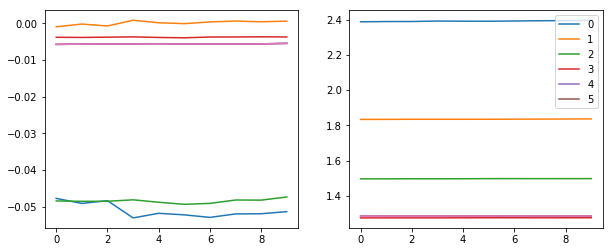

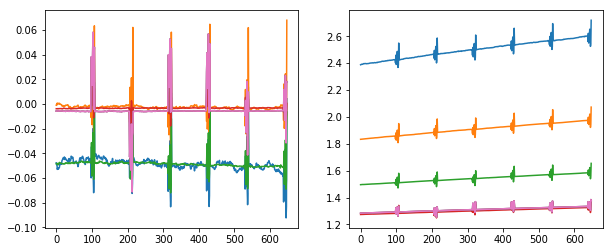

In [0]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(6, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss, hi = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss, hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

3

In [0]:
#export
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [0]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs)

In [0]:
%time run.fit(3, learn)

train: [0.2315625, tensor(0.9278, device='cuda:0')]
valid: [0.09564598388671874, tensor(0.9714, device='cuda:0')]
train: [0.0675636279296875, tensor(0.9792, device='cuda:0')]
valid: [0.07641251220703126, tensor(0.9763, device='cuda:0')]
train: [0.042631494140625, tensor(0.9871, device='cuda:0')]
valid: [0.06288768920898437, tensor(0.9813, device='cuda:0')]
CPU times: user 4.34 s, sys: 1.32 s, total: 5.65 s
Wall time: 5.7 s


### with scheduler

In [0]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 2.), sched_lin(2., 0.1)])

In [0]:
learn, run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs+[partial(ParamScheduler, 'lr', sched)])

In [0]:
run.fit(8, learn)

train: [0.262981328125, tensor(0.9204, device='cuda:0')]
valid: [0.16758890380859376, tensor(0.9500, device='cuda:0')]
train: [0.0759003076171875, tensor(0.9764, device='cuda:0')]
valid: [0.18548590087890626, tensor(0.9459, device='cuda:0')]
train: [0.0538996630859375, tensor(0.9830, device='cuda:0')]
valid: [0.1144128173828125, tensor(0.9676, device='cuda:0')]
train: [0.03191865478515625, tensor(0.9897, device='cuda:0')]
valid: [0.04680001831054687, tensor(0.9871, device='cuda:0')]
train: [0.017824248046875, tensor(0.9947, device='cuda:0')]
valid: [0.049914608764648434, tensor(0.9850, device='cuda:0')]
train: [0.01036178466796875, tensor(0.9973, device='cuda:0')]
valid: [0.04333111877441406, tensor(0.9883, device='cuda:0')]
train: [0.00574756591796875, tensor(0.9988, device='cuda:0')]
valid: [0.040669287109375, tensor(0.9876, device='cuda:0')]
train: [0.0037688397216796873, tensor(0.9995, device='cuda:0')]
valid: [0.042108389282226565, tensor(0.9876, device='cuda:0')]


### more norms

From [the paper](https://arxiv.org/abs/1607.06450): "*batch normalization cannot be applied to online learning tasks or to extremely large distributed models where the minibatches have to be small*".

General equation for a norm layer with learnable affine:

$$y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta$$

The difference with BatchNorm is
1. we don't keep a moving average
2. we don't average over the batches dimension but over the hidden dimension, so it's independent of the batch size

In [0]:
class LayerNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add  = nn.Parameter(tensor(0.))

    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.var ((1,2,3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt())
        return x*self.mult + self.add

In [0]:
def conv_ln(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(LayerNorm())
    return nn.Sequential(*layers)


In [0]:
learn,run = get_learn_run(nfs, data, 0.8, conv_ln, cbs=cbfs)


In [0]:
%time run.fit(3, learn)


train: [0.4524344140625, tensor(0.8547, device='cuda:0')]
valid: [0.11573326416015625, tensor(0.9656, device='cuda:0')]
train: [0.0997519140625, tensor(0.9693, device='cuda:0')]
valid: [0.08293680419921876, tensor(0.9740, device='cuda:0')]
train: [0.058443779296875, tensor(0.9820, device='cuda:0')]
valid: [0.066017822265625, tensor(0.9785, device='cuda:0')]
CPU times: user 5.39 s, sys: 1.55 s, total: 6.94 s
Wall time: 6.97 s


*Thought experiment*: can this distinguish foggy days from sunny days (assuming you're using it before the first conv)?

The key difference between **contrast** and batch normalization is that the latter applies the normalization to a  whole batch of images instead for single ones:

\begin{equation}\label{eq:bnorm}
    y_{tijk} =  \frac{x_{tijk} - \mu_{i}}{\sqrt{\sigma_i^2 + \epsilon}},
    \quad
    \mu_i = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H x_{tilm},
    \quad
    \sigma_i^2 = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_i)^2.
\end{equation}

In order to combine the effects of instance-specific normalization and batch normalization, we propose to replace the latter by the *instance normalization* (also known as *contrast normalization*) layer:

\begin{equation}\label{eq:inorm}
    y_{tijk} =  \frac{x_{tijk} - \mu_{ti}}{\sqrt{\sigma_{ti}^2 + \epsilon}},
    \quad
    \mu_{ti} = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H x_{tilm},
    \quad
    \sigma_{ti}^2 = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_{ti})^2.
\end{equation}

In [0]:
class InstanceNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, nf, eps=1e-0):
        super().__init__()
        self.eps = eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))

    def forward(self, x):
        m = x.mean((2,3), keepdim=True)
        v = x.var ((2,3), keepdim=True)
        res = (x-m) / ((v+self.eps).sqrt())
        return res*self.mults + self.adds

In [0]:
def conv_in(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(InstanceNorm(nf))
    return nn.Sequential(*layers)


In [0]:
learn,run = get_learn_run(nfs, data, 0.1, conv_in, cbs=cbfs)


In [0]:
%time run.fit(3, learn)

train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 5.42 s, sys: 1.55 s, total: 6.97 s
Wall time: 6.99 s


In [0]:
data = DataBunch(*get_dls(train_ds, valid_ds, 2), c)


In [0]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [0]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [0]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

To solve this problem we introduce a Running BatchNorm that uses smoother running mean and variance for the mean and std.

In [0]:
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('sums', torch.zeros(1,nf,1,1))
        self.register_buffer('sqrs', torch.zeros(1,nf,1,1))
        self.register_buffer('batch', tensor(0.))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('step', tensor(0.))
        self.register_buffer('dbias', tensor(0.))

    def update_stats(self, x):
        bs,nc,*_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0,2,3)
        s = x.sum(dims, keepdim=True)
        ss = (x*x).sum(dims, keepdim=True)
        c = self.count.new_tensor(x.numel()/nc)
        mom1 = 1 - (1-self.mom)/math.sqrt(bs-1)
        self.mom1 = self.dbias.new_tensor(mom1)
        self.sums.lerp_(s, self.mom1)
        self.sqrs.lerp_(ss, self.mom1)
        self.count.lerp_(c, self.mom1)
        self.dbias = self.dbias*(1-self.mom1) + self.mom1
        self.batch += bs
        self.step += 1

    def forward(self, x):
        if self.training: self.update_stats(x)
        sums = self.sums
        sqrs = self.sqrs
        c = self.count
        if self.step<100:
            sums = sums / self.dbias
            sqrs = sqrs / self.dbias
            c    = c    / self.dbias
        means = sums/c
        vars = (sqrs/c).sub_(means*means)
        if bool(self.batch < 20): vars.clamp_min_(0.01)
        x = (x-means).div_((vars.add_(self.eps)).sqrt())
        return x.mul_(self.mults).add_(self.adds)


In [0]:
def conv_rbn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(RunningBatchNorm(nf))
    return nn.Sequential(*layers)


In [0]:
learn,run = get_learn_run(nfs, data, 0.4, conv_rbn, cbs=cbfs)


In [0]:
%time run.fit(1, learn)


In [0]:
data = DataBunch(*get_dls(train_ds, valid_ds, 32), c)

In [0]:
learn,run = get_learn_run(nfs, data, 0.9, conv_rbn, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched_lin(1., 0.2))])

In [0]:
%time run.fit(1, learn)

In [0]:
! python notebook2script.py nb_10_fastai.ipynb